In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer

### Data Import

In [2]:
def concat_table(name_list):
    table_group = []
    for name in name_list:
        table = pd.read_sas(name)
        table_group.append(table)
    return pd.concat(table_group, sort = True)

In [3]:
slq_list = ['SLQ_D.XPT','SLQ_E.XPT','SLQ_F.XPT','SLQ_G.XPT']
slq = concat_table(slq_list)

bpx_list = ['BPX_D.XPT','BPX_E.XPT','BPX_F.XPT','BPX_G.XPT']
bpx = concat_table(bpx_list)

demo_list = ['DEMO_D.XPT','DEMO_E.XPT','DEMO_F.XPT','DEMO_G.XPT']
demo = concat_table(demo_list)

dr1_list = ['DR1TOT_D.XPT','DR1TOT_E.XPT','DR1TOT_F.XPT','DR1TOT_G.XPT']
dr1 = concat_table(dr1_list)

duq_list = ['DUQ_D.XPT','DUQ_E.XPT','DUQ_F.XPT','DUQ_G.XPT']
duq = concat_table(duq_list)

dpq_list = ['DPQ_D.XPT','DPQ_E.XPT','DPQ_F.XPT','DPQ_G.XPT']
dpq = concat_table(dpq_list)

smq_list = ['SMQ_D.XPT','SMQ_E.XPT','SMQ_F.XPT','SMQ_G.XPT','SMQ_H.XPT']
smq = concat_table(smq_list)

In [4]:
# merge dataframes
data_org = slq.merge(bpx, how = 'inner', on = 'SEQN').\
        merge(demo, how = 'inner', on = 'SEQN').\
        merge(dr1, how = 'inner', on = 'SEQN').\
        merge(duq, how = 'inner', on = 'SEQN').\
        merge(dpq, how = 'inner', on = 'SEQN').\
        merge(smq, how = 'inner', on = 'SEQN')

### Missing Value

In [5]:
#missing value
def miss_num(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
missing_data = miss_num(data_org)

In [7]:
sum(missing_data['Percent'] <= 0.2)

156

In [8]:
# get selected features
features = pd.DataFrame(missing_data['Percent'] <= 0.2)
features = features.index[features['Percent'] == True].tolist()

# get dataset with only selected features
data = data_org[features]
print(data.shape)

(18008, 156)


## Correlation Heatmap

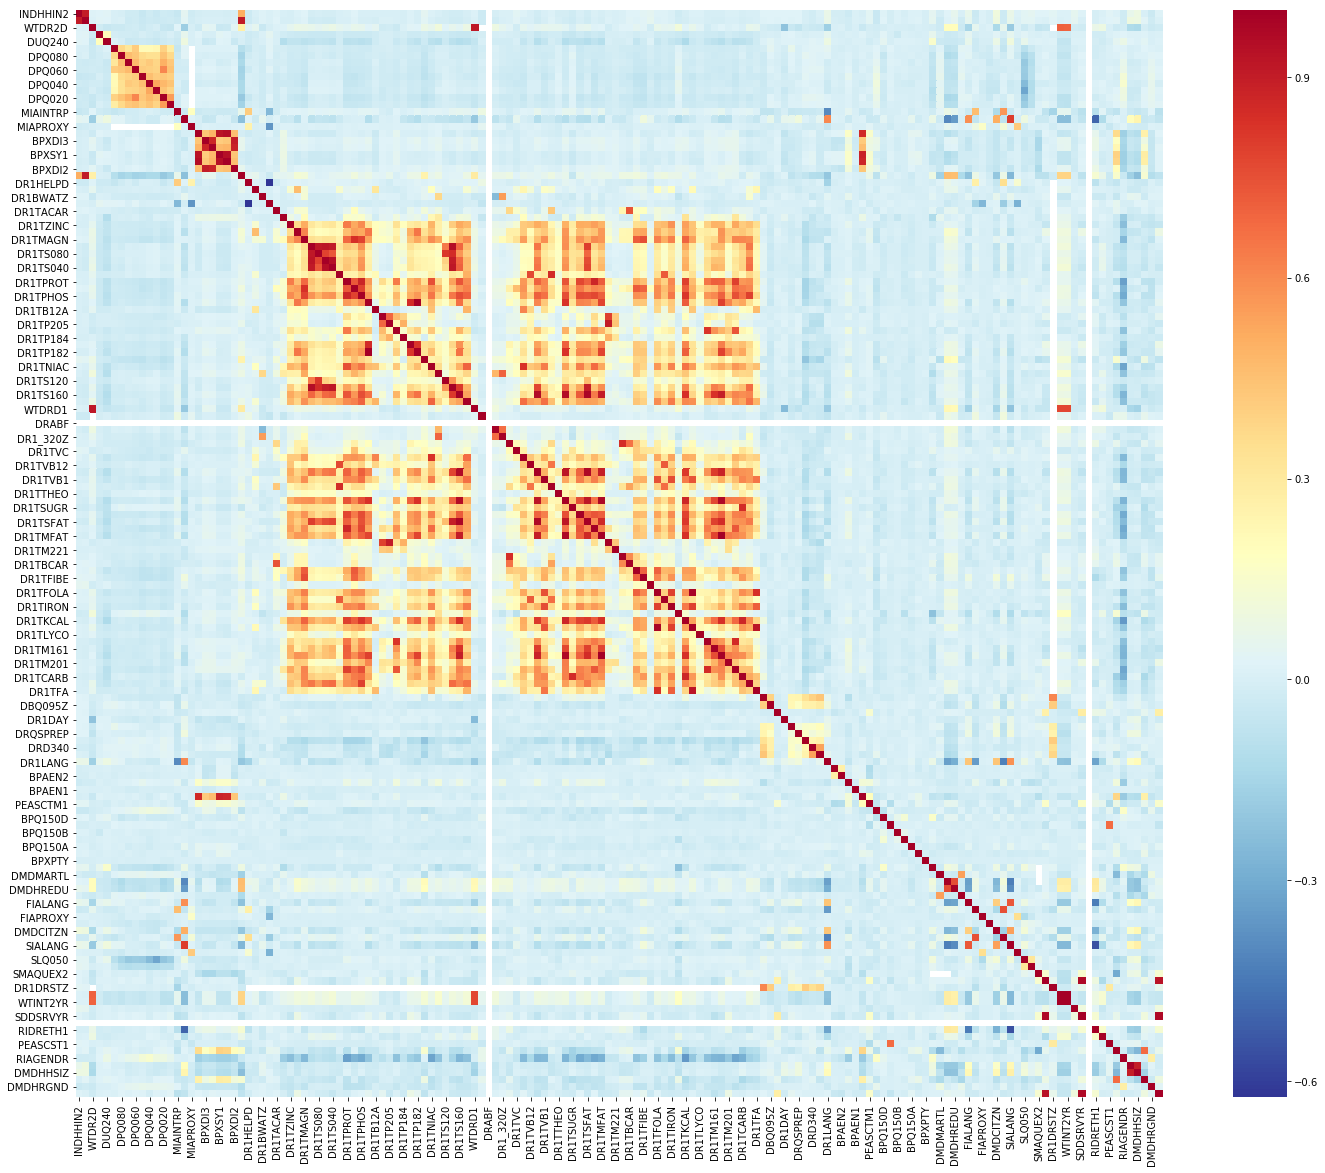

In [9]:
corrmat = data.iloc[:, :].corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corrmat, cmap = plt.cm.RdYlBu_r, vmax=1, square=True)
plt.show()

In [10]:
corrmat['SLQ060'].sort_values()

DPQ030     -0.116409
DPQ040     -0.113548
DPQ070     -0.109632
BPACSZ     -0.095362
DPQ020     -0.094694
DPQ060     -0.094686
DPQ080     -0.093427
DPQ010     -0.091515
DPQ050     -0.091361
RIDAGEYR   -0.072906
DMDHRAGE   -0.048436
FIAPROXY   -0.042174
PEASCTM1   -0.040599
DPQ090     -0.036247
BPXSY2     -0.035660
BPXSY1     -0.032550
BPXML1     -0.031780
DR1TCAFF   -0.031060
BPXSY3     -0.029676
BPXDI1     -0.027792
RIDRETH1   -0.024620
DR1TMOIS   -0.020630
BPXDI2     -0.020080
BPXDI3     -0.019710
BPXPLS     -0.019655
DR1_330Z   -0.018197
DR1_320Z   -0.017386
BPAARM     -0.016649
DR1TATOA   -0.015914
DMDHRGND   -0.015499
              ...   
DRQSPREP    0.014343
DR1TVK      0.014637
INDFMPIR    0.014986
DR1TPFAT    0.015121
DR1TCHL     0.015564
DUQ240      0.015637
DR1TPHOS    0.016514
DR1TVB6     0.016519
DR1TKCAL    0.017421
DR1TBCAR    0.018198
DR1TP183    0.019164
DR1TCARB    0.020444
DR1LANG     0.022593
DR1TWS      0.026648
MIALANG     0.030170
SMAQUEX2    0.030795
FIALANG     0

In [11]:
feature_sel = corrmat.loc[(corrmat['SLQ060']>0.03) | (corrmat['SLQ060']< -0.03)].index
data_sel = data[feature_sel]
print(data_sel.shape)
print(feature_sel)

(18008, 32)
Index(['INDHHIN2', 'INDFMIN2', 'DPQ090', 'DPQ080', 'DPQ070', 'DPQ060',
       'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020', 'DPQ010', 'MIALANG', 'BPXSY1',
       'BPXSY2', 'DR1TCAFF', 'DRQSDIET', 'BPACSZ', 'BPXML1', 'PEASCTM1',
       'SMQ020', 'FIALANG', 'FIAPROXY', 'SLD010H', 'DMDCITZN', 'SIALANG',
       'SLQ050', 'SLQ060', 'SMAQUEX2', 'RIDAGEYR', 'DMDFMSIZ', 'DMDHHSIZ',
       'DMDHRAGE'],
      dtype='object')


### Data Preprocessing

In [12]:
categorical = ['INDHHIN2', 'INDFMIN2', 'DPQ090', 'DPQ070', 'DPQ080', 'DPQ060',
                   'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020', 'DPQ010', 'MIALANG', 'DRQSDIET', 'BPACSZ',
                   'SMQ020', 'FIAPROXY', 'DMDCITZN', 'SIALANG','SLQ050', 'SLQ060','FIALANG','SMAQUEX2']

In [13]:
def process_category(data):
    categorical = ['INDHHIN2', 'INDFMIN2', 'DPQ090', 'DPQ070', 'DPQ080', 'DPQ060',
                   'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020', 'DPQ010', 'MIALANG', 'DRQSDIET', 'BPACSZ',
                   'SMQ020', 'FIAPROXY', 'DMDCITZN', 'SIALANG','SLQ050', 'SLQ060','FIALANG','SMAQUEX2']
    numerical = ['BPXSY1','BPXML1', 'BPXSY2', 'DR1TCAFF', 'PEASCTM1', 'SLD010H',
                'RIDAGEYR', 'DMDHRAGE', 'DMDHHSIZ', 'DMDFMSIZ']
    #剔除9
    for i in ['DMDCITZN','DPQ090','DPQ070','DPQ080','DPQ060','DPQ050','DPQ040','DPQ030','DPQ020','DPQ010'
              ,'SLQ050','SLQ060']:
        data = data[~data[i].isin([9])]    
    #剔除99
    for i in ['INDHHIN2','INDFMIN2']:
        data = data[~data[i].isin([99])]  
    for i in categorical:
        data[i] = data[i].fillna(data[i].mode()[0])
    #data = pd.get_dummies(data, dummy_na = True)
    data.dropna(inplace = True)
    return data
    
def process_numerical(data):   
    for i in numerical:
        data[i] = data[i].fillna(data[i].mean()[0])
    return data    

In [14]:
def process_data(data):
# convert categorical variables
    categorical = ['INDHHIN2', 'INDFMIN2', 'DPQ090', 'DPQ070', 'DPQ080', 'DPQ060',
                   'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020', 'DPQ010', 'MIALANG', 'DRQSDIET', 'BPACSZ',
                   'SMQ020', 'FIAPROXY', 'DMDCITZN', 'SIALANG','SLQ050', 'SLQ060','FIALANG','SMAQUEX2']
    numerical = ['BPXSY1','BPXML1', 'BPXSY2', 'DR1TCAFF', 'PEASCTM1', 'SLD010H',
                'RIDAGEYR', 'DMDHRAGE', 'DMDHHSIZ', 'DMDFMSIZ','SLQ060']
    data_cat = data[categorical]
    data_cat = data_cat.round(0)
    # filter out unlabeled data
    data_cat = pd.concat([data_cat[data_cat['SLQ060'] == 1], data_cat[data_cat['SLQ060'] == 2]], axis = 0)
    #data_cat = pd.get_dummies(data_cat, dummy_na = True)
    data_cat = process_category(data_cat)
    data_cat = data_cat.astype('category')
    data_cat = pd.get_dummies(data_cat, dummy_na = True)
    data_cat = data_cat.drop(['SLQ060_1.0','SLQ060_2.0'], axis = 1)
    
    data_num = data[numerical]
    data_num.fillna(method='ffill',inplace = True)
    data_num.fillna(method='bfill',inplace = True)
    data_all = pd.concat([data_cat, data_num], axis = 1)
    data = pd.DataFrame(data_all.round(0))
    
    return data

In [15]:
data_process =  process_data(data_sel).dropna()

/Users/josephzeng/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [16]:
def get_x(data):
    cols = [i for i in data_process.columns if i not in ['SLQ060','DPQ060_7.0', 'DPQ050_7.0', 'DPQ040_7.0', 'DPQ030_7.0', 'SMQ020_7.0', 'SMQ020_9.0', 'SMAQUEX2_2.0']]
    X = data[cols]
    #(X-X.mean())/X.std()
    return X
def get_y(data):
    Y = data['SLQ060']
    Y.replace(2,0, inplace = True)
    return Y

In [17]:
X = get_x(data_process)
Y = get_y(data_process)

In [18]:
X.shape

(17624, 127)

#### Feature importance

In [19]:
from sklearn.ensemble import RandomForestClassifier
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
rf_imp = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=2018)
rf_imp.fit(X, Y)
features = X.columns.values[:20]

In [20]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf_imp, X, Y, r2).head(20)
perm_imp_rfpimp

,Importance
Feature,
SLQ050_1.0,0.168444
SLQ050_2.0,0.162830
BPACSZ_5.0,0.106681
BPXSY1,0.056148
SLD010H,0.053341
PEASCTM1,0.044918
BPXSY2,0.042111
RIDAGEYR,0.039304
DPQ040_3.0,0.033689


[Text(0,0,'SLQ050_1.0'),
 Text(0,0,'SLQ050_2.0'),
 Text(0,0,'BPACSZ_5.0'),
 Text(0,0,'BPXSY1'),
 Text(0,0,'SLD010H'),
 Text(0,0,'PEASCTM1'),
 Text(0,0,'BPXSY2'),
 Text(0,0,'RIDAGEYR'),
 Text(0,0,'DPQ040_3.0'),
 Text(0,0,'DR1TCAFF'),
 Text(0,0,'DPQ070_3.0'),
 Text(0,0,'DMDFMSIZ'),
 Text(0,0,'BPACSZ_4.0'),
 Text(0,0,'DPQ030_3.0'),
 Text(0,0,'DMDHHSIZ'),
 Text(0,0,'DPQ050_3.0'),
 Text(0,0,'BPACSZ_3.0'),
 Text(0,0,'DMDHRAGE'),
 Text(0,0,'DPQ050_1.0'),
 Text(0,0,'DPQ080_0.0')]

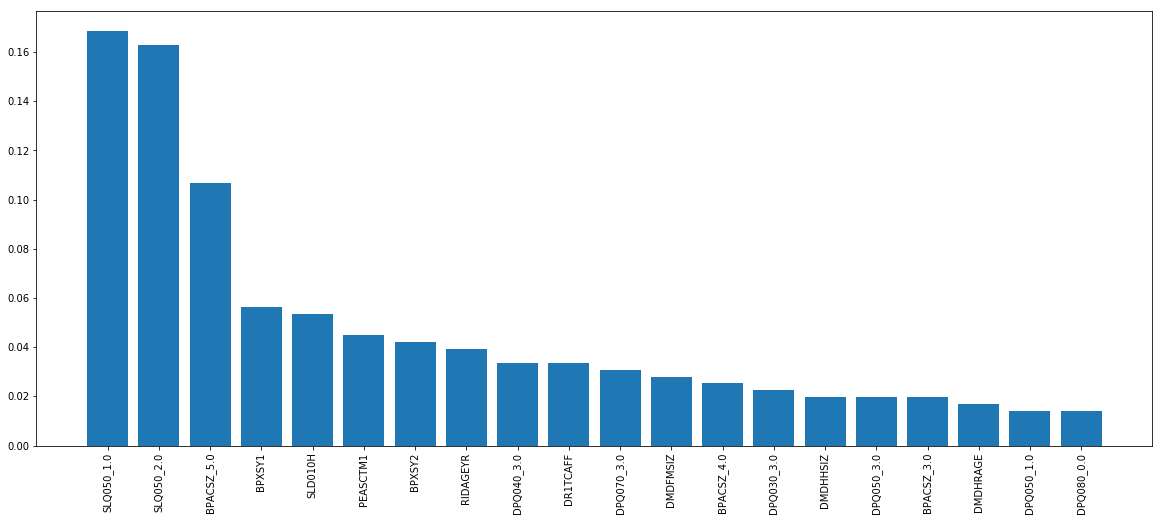

In [21]:
fig, ax = plt.subplots(figsize = (20,8))
plt.bar(perm_imp_rfpimp.index, perm_imp_rfpimp['Importance'])
ax.set_xticklabels(perm_imp_rfpimp.index, rotation=90)

In [22]:
from sklearn.preprocessing import scale
X = scale(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state = 25)

### Model Training

#### 1.KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 22)
knn.fit(X_train, y_train)
predict_knn_y = knn.predict_proba(X_test)
#predict_knn_y = knn.predict(X_test)
knn_auc = metrics.roc_auc_score(y_test,predict_knn_y[:,1])
#knn_recall = metrics.recall_score(y_test, predict_knn_y, average='micro')
print('accuracy:', knn.score(X_test, y_test))
print('auc:',knn_auc)

#print('recall:', knn_recall)
#print('Recall', metrics.recall_score(y_test, predict_knn_y[:,1]))

accuracy: 0.9214707217430776
auc: 0.8110271261808151


<Figure size 432x288 with 0 Axes>

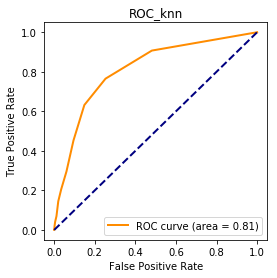

In [25]:
from sklearn.metrics import roc_curve,auc
fpr_knn,tpr_knn,threshold_knn = roc_curve(y_test,predict_knn_y[:,1])
#roc_auc = auc(fpr,tpr) 

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_knn, tpr_knn, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % knn_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_knn')
plt.legend(loc="lower right")
plt.show()

#### 2.Random Forest

<Figure size 432x288 with 0 Axes>

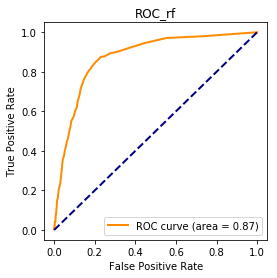

accuracy: 0.9223785746709033
auc: 0.8749397770949543


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predict_rf_y = rf.predict_proba(X_test)
rf_auc = metrics.roc_auc_score(y_test,predict_rf_y[:,1])

fpr_rf,tpr_rf,threshold_rf = roc_curve(y_test,predict_rf_y[:,1])
#roc_auc = auc(fpr,tpr) 

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_rf')
plt.legend(loc="lower right")
plt.show()
print('accuracy:', rf.score(X_test, y_test))
print('auc:',rf_auc)

#### 3.xgboost

<Figure size 432x288 with 0 Axes>

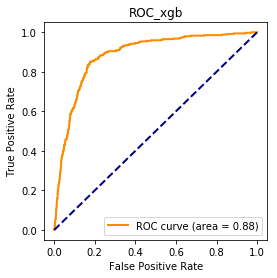

accuracy: 0.9196550158874263
auc: 0.8843281265055727


/Users/josephzeng/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [27]:
import xgboost as xgb
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred_xgb_y = xgb.predict_proba(X_test)
xgb_auc = metrics.roc_auc_score(y_test,pred_xgb_y[:,1])

fpr_xgb,tpr_xgb,threshold_xgb = roc_curve(y_test,pred_xgb_y[:,1])

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % xgb_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_xgb')
plt.legend(loc="lower right")
plt.show()
print('accuracy:', xgb.score(X_test, y_test))
print('auc:',xgb_auc)

#### 4.Logistic Regression

accuracy: 0.9203359055832955
auc: 0.8831343746988856


<Figure size 432x288 with 0 Axes>

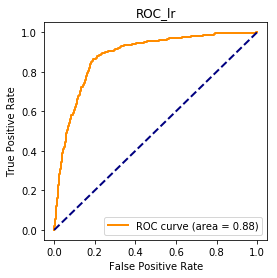

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc
lr = LogisticRegression(C=800, random_state=0)
lr.fit(X_train, y_train)
predict_lr_y = lr.decision_function(X_test)
lr_auc = metrics.roc_auc_score(y_test,predict_lr_y)
print('accuracy:', lr.score(X_test, y_test))
print('auc:',lr_auc)

fpr_lr,tpr_lr,threshold_lr = roc_curve(y_test,predict_lr_y)
plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_lr')
plt.legend(loc="lower right")
plt.show()

# Test Set

### Data Input

In [29]:
slq_list_t = ['SLQ_H.XPT']
slq_t = concat_table(slq_list_t)

bpx_list_t = ['BPX_H.XPT']
bpx_t = concat_table(bpx_list_t)

demo_list_t = ['DEMO_H.XPT']
demo_t = concat_table(demo_list_t)

dr1_list_t = ['DR1TOT_H.XPT']
dr1_t = concat_table(dr1_list_t)

duq_list_t = ['DUQ_H.XPT']
duq_t = concat_table(duq_list_t)

dpq_list_t = ['DPQ_H.XPT']
dpq_t = concat_table(dpq_list_t)

smq_list_t = ['SMQ_H.XPT']
smq_t = concat_table(smq_list_t)

# merge dataframes
data_org_t = slq_t.merge(bpx_t, how = 'inner', on = 'SEQN').\
        merge(demo_t, how = 'inner', on = 'SEQN').\
        merge(dr1_t, how = 'inner', on = 'SEQN').\
        merge(duq_t, how = 'inner', on = 'SEQN').\
        merge(dpq_t, how = 'inner', on = 'SEQN').\
        merge(smq_t, how = 'inner', on = 'SEQN')

### Data Preprocessing

In [30]:
# get selected features
features_t = pd.DataFrame(miss_num(data_org_t)['Percent'] <= 0.2)
features_t = features_t.index[features_t['Percent'] == True].tolist()

# get dataset with only selected features
data_t = data_org_t[features_t]
print(data_t.shape)

(5057, 163)


In [31]:
data_sel_t = data_t[feature_sel]

In [32]:
data_process_t =  process_data(data_sel_t).dropna()

/Users/josephzeng/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [33]:
data_process.shape

(17624, 135)

In [34]:
data_process_t =  process_data(data_sel_t).dropna()
#X_v = get_x(data_process_t)
X_v = data_process_t[[i for i in data_process_t.columns if i not in ['SLQ060']]]
X_v = scale(X_v)
Y_v = get_y(data_process_t)

/Users/josephzeng/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [35]:
X_v.shape

(5000, 127)

### Model Test

#### 1.KNN

accuracy: 0.907
auc: 0.8006181313795925


<Figure size 432x288 with 0 Axes>

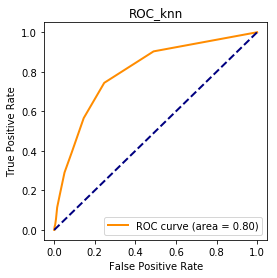

In [36]:
test_predict_knn_y = knn.predict_proba(X_v)
test_knn_auc = metrics.roc_auc_score(Y_v,test_predict_knn_y[:,1])
print('accuracy:', knn.score(X_v, Y_v))
print('auc:',test_knn_auc)

fpr_knn,tpr_knn,threshold_knn = roc_curve(Y_v,test_predict_knn_y[:,1])
#roc_auc = auc(fpr,tpr) 

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_knn, tpr_knn, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_knn_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_knn')
plt.legend(loc="lower right")
plt.show()

#### 2.Random Forest

<Figure size 432x288 with 0 Axes>

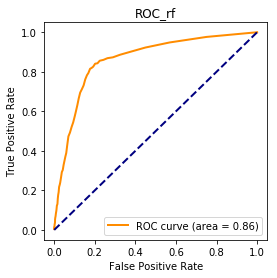

accuracy: 0.907
auc: 0.8610975566383328


In [37]:
test_predict_rf_y = rf.predict_proba(X_v)
test_rf_auc = metrics.roc_auc_score(Y_v,test_predict_rf_y[:,1])

fpr_rf,tpr_rf,threshold_rf = roc_curve(Y_v,test_predict_rf_y[:,1])
#roc_auc = auc(fpr,tpr) 

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_rf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_rf')
plt.legend(loc="lower right")
plt.show()
print('accuracy:', rf.score(X_v,Y_v))
print('auc:', test_rf_auc)

#### 3.xgboost

<Figure size 432x288 with 0 Axes>

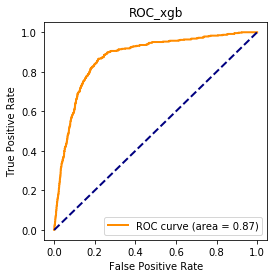

accuracy: 0.906
auc: 0.873805408353191


/Users/josephzeng/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [38]:
test_pred_xgb_y = xgb.predict_proba(X_v)
test_xgb_auc = metrics.roc_auc_score(Y_v,test_pred_xgb_y[:,1])

fpr_xgb,tpr_xgb,threshold_xgb = roc_curve(Y_v,test_pred_xgb_y[:,1])

plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_xgb_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_xgb')
plt.legend(loc="lower right")
plt.show()
print('accuracy:', xgb.score(X_v, Y_v))
print('auc:',test_xgb_auc)

#### 4.Logistic Regression

accuracy: 0.9068
auc: 0.8668065583099194


<Figure size 432x288 with 0 Axes>

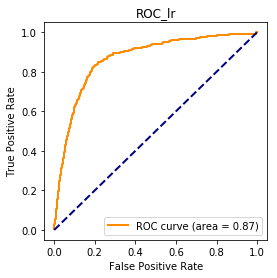

In [39]:
test_predict_lr_y = lr.decision_function(X_v)
test_lr_auc = metrics.roc_auc_score(Y_v,test_predict_lr_y)
print('accuracy:', lr.score(X_v, Y_v))
print('auc:',test_lr_auc)

fpr_lr,tpr_lr,threshold_lr = roc_curve(Y_v,test_predict_lr_y)
plt.figure()
lw = 2
plt.figure(figsize=(4,4))
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_lr_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_lr')
plt.legend(loc="lower right")
plt.show()